In [10]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
batch_size = 64

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train = True, download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

testset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train = False, download = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [21]:
class learned_relu(nn.Module):
    def __init__(self, k0 = 1, k1 = 1):
        super().__init__()
        ones = torch.tensor([1.0])
        self.k0 = nn.Parameter(k0 * ones)
        self.k1 = nn.Parameter(k1 * ones)
        
    def forward(self, x):
        return self.k1 * x + self.k0

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.output = nn.Linear(784, 10)
        self.LReLU = learned_relu()
        
    def forward(self, x):
        x = self.output(x)
        x = self.LReLU(x)
        
        return x
    
model = Network()
model

Network(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (LReLU): learned_relu()
)

In [22]:
print(model.LReLU.k0)
print(model.LReLU.k1)

Parameter containing:
tensor([1.], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


In [23]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
epochs = 75
train_loss = []
test_loss = []
k0_val = []
k1_val = []
for e in range(1,epochs+1):
    running_loss = 0
    train_correct = 0
    for images, labels in trainloader:
        input = images.resize_(images.shape[0],torch.numel(images[0]))

        output = model(input)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        train_correct += np.sum(np.argmax(torch.nn.functional.softmax(output, dim=1).detach().numpy(), axis=1) == labels.detach().numpy())        

    train_loss.append(running_loss)
        
    k0_val.append(model.LReLU.k0)
    k1_val.append(model.LReLU.k1)
    test_correct = 0
    # Set model to evaluation mode before testing to disable dropout!!!
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            input = images.resize_(images.shape[0],torch.numel(images[0]))
            output = model(input)
            loss = criterion(output, labels)
            running_loss += loss.item()
            test_correct += np.sum(np.argmax(torch.nn.functional.softmax(output, dim=1).detach().numpy(), axis=1) == labels.detach().numpy())

    test_loss.append(running_loss)
        
    train_accuracy = 100 * train_correct / len(trainset)
    test_accuracy = 100 * test_correct / len(testset)
    print("Epoch: %d, Train accuracy: %lf, Test accuracy: %lf"%(e, train_accuracy, test_accuracy))

Epoch: 1, Train accuracy: 55.153333, Test accuracy: 75.830000
Epoch: 2, Train accuracy: 79.476667, Test accuracy: 83.040000
Epoch: 3, Train accuracy: 83.498333, Test accuracy: 85.800000
Epoch: 4, Train accuracy: 85.418333, Test accuracy: 87.170000
Epoch: 5, Train accuracy: 86.558333, Test accuracy: 87.890000
Epoch: 6, Train accuracy: 87.371667, Test accuracy: 88.550000
Epoch: 7, Train accuracy: 87.950000, Test accuracy: 88.920000
Epoch: 8, Train accuracy: 88.413333, Test accuracy: 89.210000
Epoch: 9, Train accuracy: 88.783333, Test accuracy: 89.750000
Epoch: 10, Train accuracy: 89.063333, Test accuracy: 89.930000
Epoch: 11, Train accuracy: 89.330000, Test accuracy: 90.270000
Epoch: 12, Train accuracy: 89.516667, Test accuracy: 90.500000
Epoch: 13, Train accuracy: 89.740000, Test accuracy: 90.600000
Epoch: 14, Train accuracy: 89.881667, Test accuracy: 90.670000
Epoch: 15, Train accuracy: 90.066667, Test accuracy: 90.800000
Epoch: 16, Train accuracy: 90.183333, Test accuracy: 90.820000
E

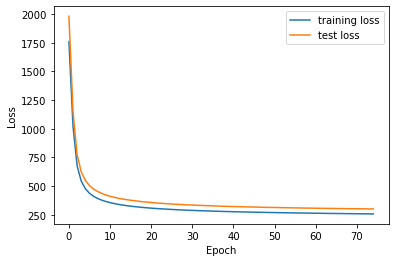

Text(0, 0.5, 'k1 parameter')

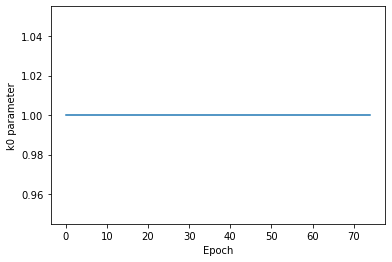

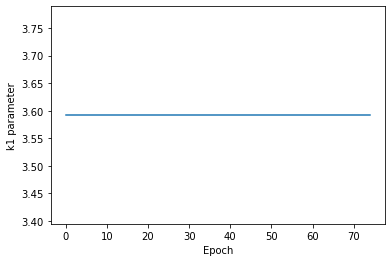

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = 'training loss')
plt.plot(test_loss, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(k0_val)
plt.xlabel('Epoch')
plt.ylabel('k0 parameter')
plt.figure()
plt.plot(k1_val)
plt.xlabel('Epoch')
plt.ylabel('k1 parameter')